In [1]:
import paddle
import paddle.nn.functional as F
from paddle.vision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(paddle.__version__)

0.0.0


In [3]:
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

def train(model):
    print('start training ... ')
    # turn into training mode
    model.train()

    opt = paddle.optimizer.Adam(learning_rate=learning_rate,
                                parameters=model.parameters())

    train_loader = paddle.io.DataLoader(cifar10_train,
                                        shuffle=True,
                                        batch_size=batch_size)

    valid_loader = paddle.io.DataLoader(cifar10_test, batch_size=batch_size)
    
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)

            if batch_id % 1000 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[validation] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        val_acc_history.append(avg_acc)
        val_loss_history.append(avg_loss)
        model.train()

In [4]:
transform = ToTensor()
cifar10_train = paddle.vision.datasets.Cifar10(mode='train',transform=transform)
cifar10_test = paddle.vision.datasets.Cifar10(mode='test',transform=transform)

In [5]:
epoch_num = 10
batch_size = 32
learning_rate = 0.001

In [6]:
val_acc_history = []
val_loss_history = []

In [7]:
model = MyNet(num_classes=10)
train(model)

start training ... 
epoch: 0, batch_id: 0, loss is: [3.2845378]
epoch: 0, batch_id: 1000, loss is: [1.3948116]
[validation] accuracy/loss: 0.5836661458015442/1.1653835773468018
epoch: 1, batch_id: 0, loss is: [1.144439]
epoch: 1, batch_id: 1000, loss is: [1.1942663]
[validation] accuracy/loss: 0.6434704661369324/1.031117558479309
epoch: 2, batch_id: 0, loss is: [0.831321]
epoch: 2, batch_id: 1000, loss is: [0.87210596]
[validation] accuracy/loss: 0.6618410348892212/0.9784349799156189
epoch: 3, batch_id: 0, loss is: [0.672575]
epoch: 3, batch_id: 1000, loss is: [0.6300676]
[validation] accuracy/loss: 0.686601459980011/0.9077011942863464
epoch: 4, batch_id: 0, loss is: [0.73849106]
epoch: 4, batch_id: 1000, loss is: [0.88693655]
[validation] accuracy/loss: 0.7006788849830627/0.8727331161499023
epoch: 5, batch_id: 0, loss is: [0.59032416]
epoch: 5, batch_id: 1000, loss is: [0.7351847]
[validation] accuracy/loss: 0.7043730020523071/0.8553281426429749
epoch: 6, batch_id: 0, loss is: [0.5243

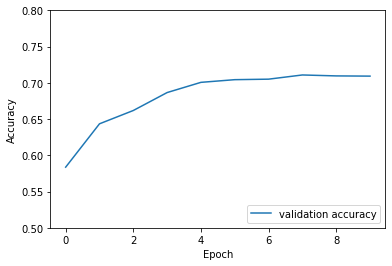

In [8]:
plt.plot(val_acc_history, label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.8])
plt.legend(loc='lower right')

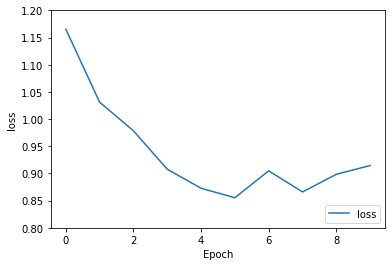

In [11]:
plt.plot(val_loss_history, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.8, 1.2])
plt.legend(loc='lower right')